# Final Results 2016-2017

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

In [3]:
db = CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-12-14 00:00:00.000000'
labeled = db.query_tagged_anomalies(start_date, end_date)
ELB = db.query_elogbook(start_date, end_date)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-12-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-12-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## PCA

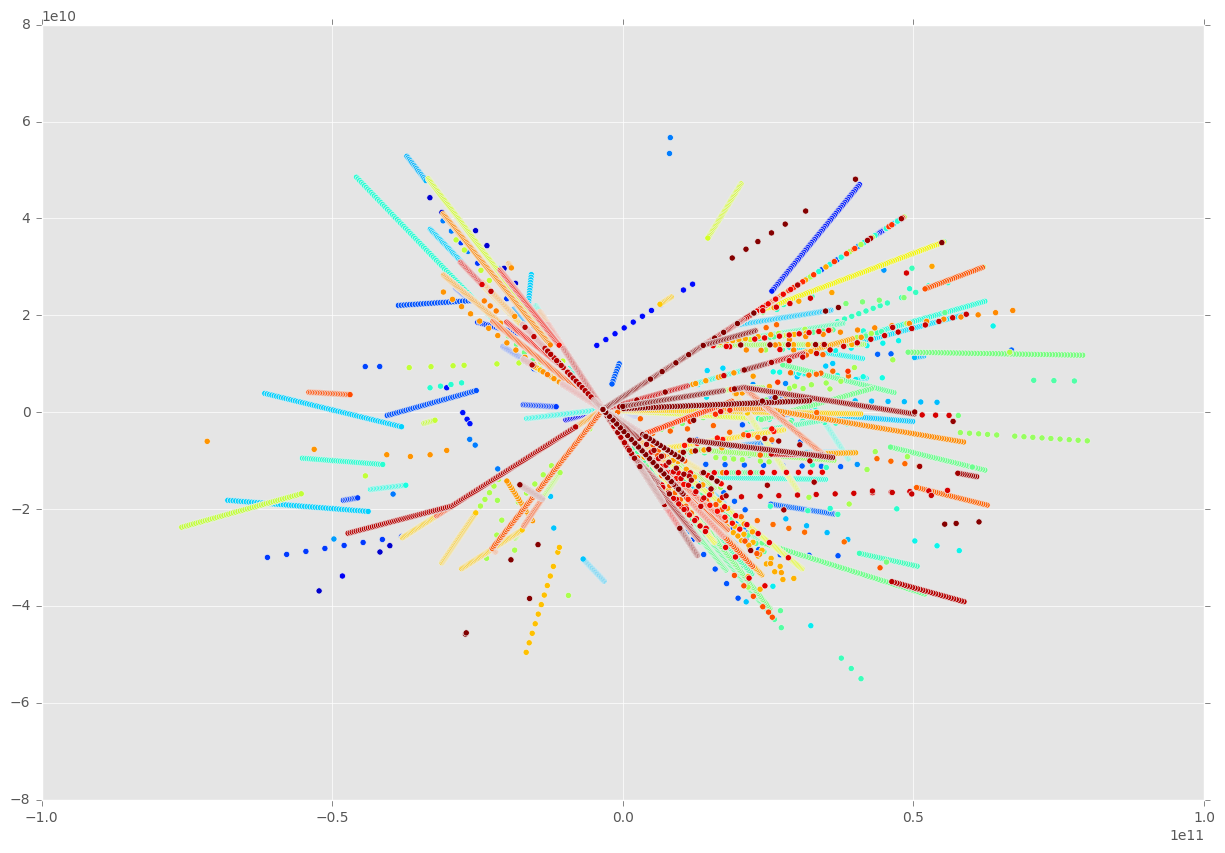

In [4]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(B1_30_s, pca)
t = np.arange(pca_data.shape[0])
plt.figure(figsize=(15, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=t)
plt.show()

In [5]:
clf_B1 = mixture.GaussianMixture(n_components=2, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=2, covariance_type='tied')
clf_B2.fit(B2_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [6]:
B1_w_probs = GMM.add_sorted_anomaly_probs(clf_B1, B1_30_s)
B2_w_probs = GMM.add_sorted_anomaly_probs(clf_B2, B2_30_s)
B1_w_probs['timestamp'] = B1_w_probs.index
B2_w_probs['timestamp'] = B2_w_probs.index

## Log prob over time

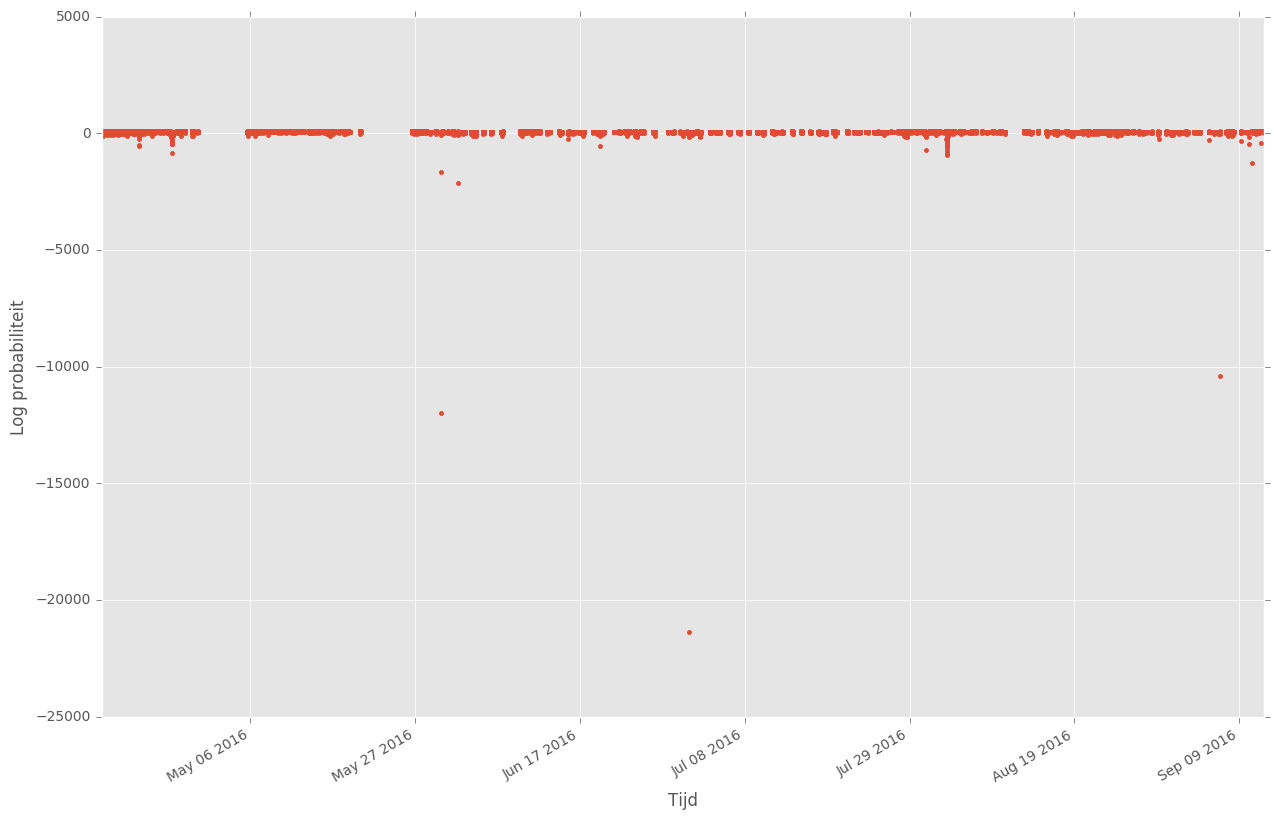

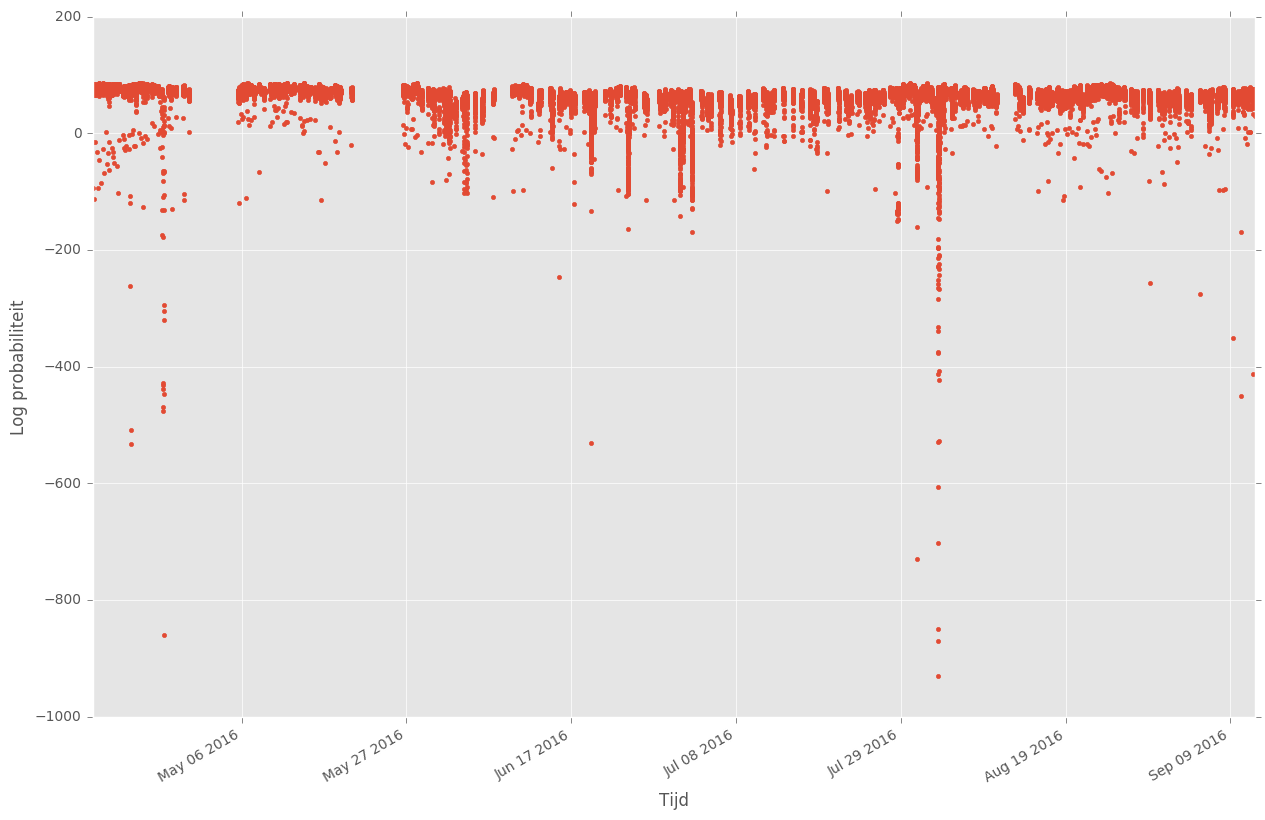

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B1_w_probs.plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B1_w_probs[B1_w_probs['log_prob']>-1000].plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

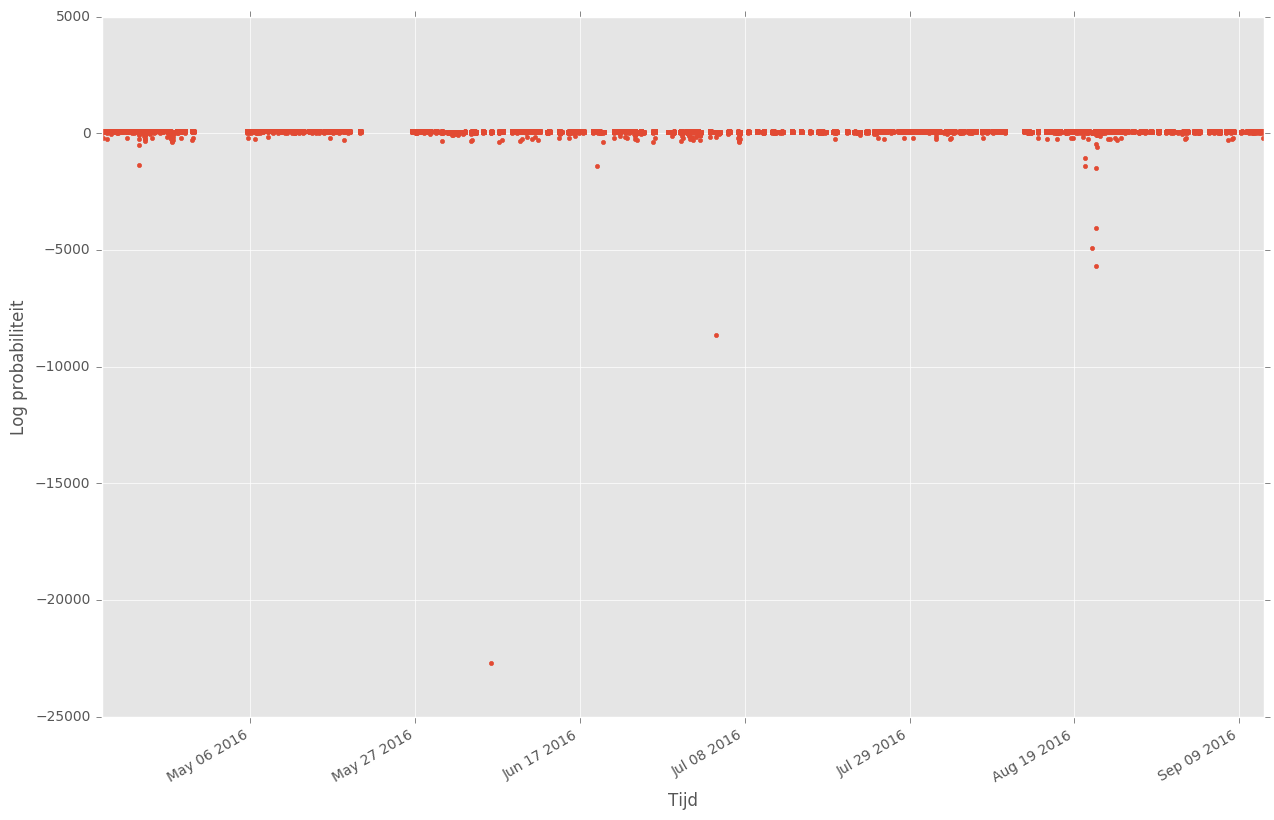

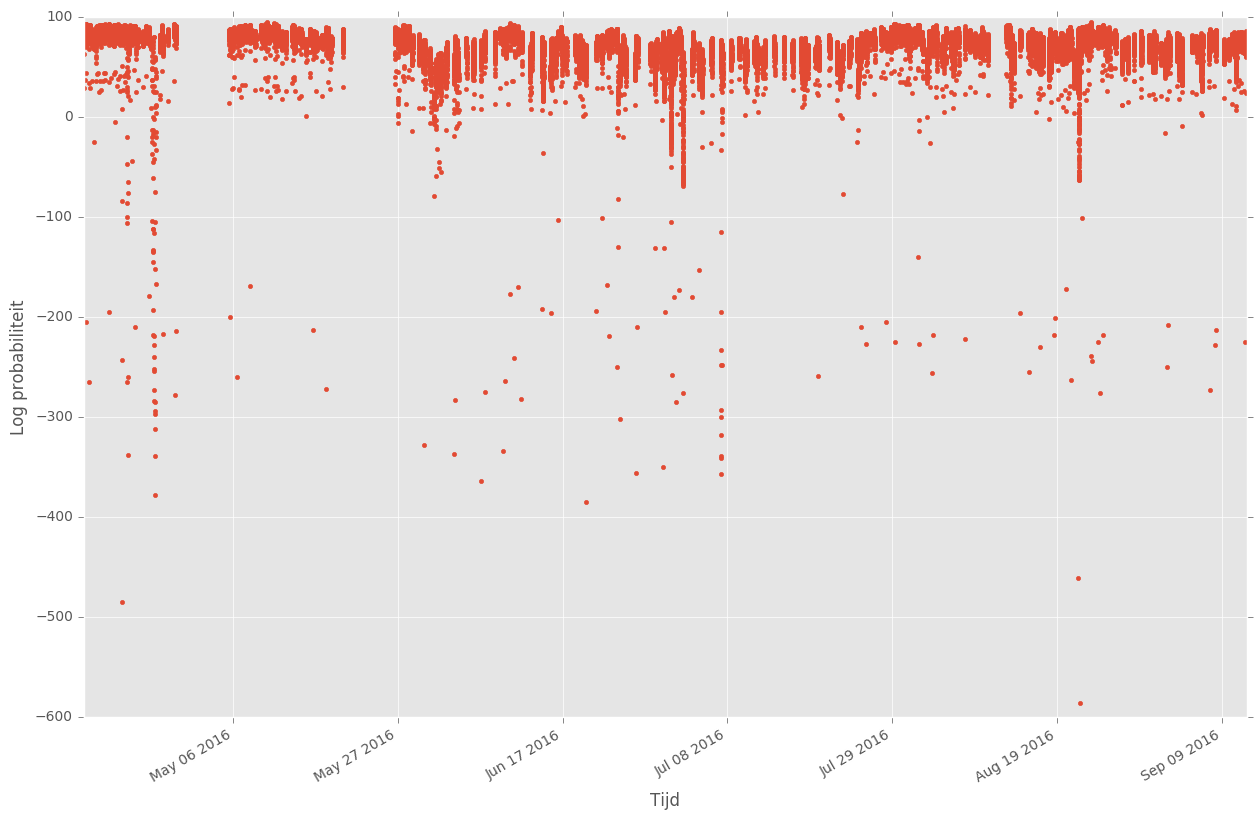

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B2_w_probs.plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B2_w_probs[B2_w_probs['log_prob']>-1000].plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

## Segments

In [9]:
anomaly_sizes = [100, 200, 250, 500]
segmenter = evaluation.AnomalySegmenter()
evolution_segments_B1 = list(segmenter.segments_generator(B1_w_probs, anomaly_sizes))
evolution_segments_B2 = list(segmenter.segments_generator(B2_w_probs, anomaly_sizes))

In [10]:
tables = [evaluation.compare_segmented_with_labeled(segments_B1, segments_B2, labeled)
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [11]:
# total_segmented_Bx computes the total number of anomalies in all segments for every step in the evolution
total_segmented_B1 = [sum([s.get_nb_anomalies() for s in segments_B1]) for segments_B1 in evolution_segments_B1]
total_segmented_B2 = [sum([s.get_nb_anomalies() for s in segments_B2]) for segments_B2 in evolution_segments_B2]

# total number of segments in each step
nb_segments_B1 = [len(segments_B1) for segments_B1 in evolution_segments_B1]
nb_segments_B2 = [len(segments_B2) for segments_B2 in evolution_segments_B2]

tag_totals = pd.DataFrame(ELB.groupby('VALUE')['TAG'].value_counts())
tag_totals.columns = ['Total_tags']
def count_detected(segments_B1, segments_B2, labels):
    labeled_w_detected = labels.copy()
    labeled_w_detected["detected"] = False
    for label in labeled_w_detected.index:
        ts = labeled_w_detected.loc[label, 'timestamps']
        if labeled_w_detected.loc[label, 'VALUE'] == 'MKI2':
            for segment in segments_B1:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True                                                
        elif labeled_w_detected.loc[label, 'VALUE'] == 'MKI8':
            for segment in segments_B2:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True
                        
    detected = labeled_w_detected[labeled_w_detected['detected'] == True]
    detected_totals = pd.DataFrame(detected.groupby(['VALUE', 'TAG'])['detected'].value_counts())
    detected_totals.index = detected_totals.index.droplevel(2)
    detected_totals.columns = ['Total_detected']
    return detected_totals

def count_segments_w_labels(segments_B1, segments_B2, ELB):
    ELB_relevant = ELB[ELB['TAG']!='info']
    B1_label = 0
    B1_no_label = 0
    B2_label = 0
    B2_no_label = 0
    for segment in segments_B1:
        label_found = False
        for label in ELB_relevant.index:
            ts = ELB_relevant.loc[label, 'timestamps']
            if ELB_relevant.loc[label, 'VALUE'] == 'MKI2':
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                    B1_label += 1
                    label_found = True
                    break
        if not label_found:
            B1_no_label += 1
    for segment in segments_B2:
        label_found = False
        for label in ELB_relevant.index:
            ts = ELB_relevant.loc[label, 'timestamps']
            if ELB_relevant.loc[label, 'VALUE'] == 'MKI8':
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                    B2_label += 1
                    label_found = True
                    break
        if not label_found:
            B2_no_label += 1
    return B1_label, B1_no_label, B2_label, B2_no_label

# timestamps are not unique => use event id as index
ELB2 = ELB.copy()
ELB2['timestamps'] = ELB2.index
ELB2.index = ELB2['EVENT_ID']
all_detected_totals = [tag_totals.join(count_detected(segments_B1, segments_B2, ELB2))
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

all_label_nolabel = [count_segments_w_labels(segments_B1, segments_B2, ELB2)
                     for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [12]:
for i in range(len(anomaly_sizes)):
#     display(tables[i])
    display("Number of anomalies used: {}".format(anomaly_sizes[i]))
    display("Number of anomalies in segments B1: {}".format(total_segmented_B1[i]))
    display("Number of anomalies in segments B2: {}".format(total_segmented_B2[i]))
    display("Total number of segments B1: {}".format(nb_segments_B1[i]))
    display("Total number of segments B2: {}".format(nb_segments_B2[i]))
    display("Number of segments with label B1: {}".format(all_label_nolabel[i][0]))
#     display("Number of segments without label B1: {}".format(all_label_nolabel[i][1]))
    display("Number of segments with label B2: {}".format(all_label_nolabel[i][2]))
#     display("Number of segments without label B2: {}".format(all_label_nolabel[i][3]))
    display("Precision B1: {}".format(all_label_nolabel[i][0]/float(nb_segments_B1[i])))
    display("Precision B2: {}".format(all_label_nolabel[i][2]/float(nb_segments_B2[i])))
    detected_totals = all_detected_totals[i]
    detected_totals['recall'] = detected_totals['Total_detected'] / detected_totals['Total_tags'] * 100
    detected_totals.fillna(0, inplace=True)
    idx = pd.IndexSlice
    detected_totals.sort_index(ascending=True, inplace=True)
    tbl_B1 = detected_totals.loc[idx['MKI2', ['anomaly', 'fault', 'intervention', 'research']], :]
    recall_B1 = tbl_B1['Total_detected'].sum() / float(tbl_B1['Total_tags'].sum())
    tbl_B2 = detected_totals.loc[idx['MKI8', ['anomaly', 'fault', 'intervention', 'research']], :]
    recall_B2 = tbl_B2['Total_detected'].sum() / float(tbl_B2['Total_tags'].sum())
    display("Recall B1: {}".format(recall_B1))
    display("Recall B2: {}".format(recall_B2))
    display(detected_totals)

'Number of anomalies used: 100'

'Number of anomalies in segments B1: 100'

'Number of anomalies in segments B2: 100'

'Total number of segments B1: 20'

'Total number of segments B2: 53'

'Number of segments with label B1: 6'

'Number of segments with label B2: 7'

'Precision B1: 0.3'

'Precision B2: 0.132075471698'

'Recall B1: 0.307692307692'

'Recall B2: 0.266666666667'